In [ ]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from sklearn.model_selection import train_test_split
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.optim as optim
import numpy as np

In [ ]:
# Read the CSV file with specified column types
data = pd.read_csv(
    'data_2.csv',
    dtype={
        'Rate': 'float64',
        'Currency': 'string',
        'Maturity': 'string',
        'Year': 'int64'
    },
    parse_dates=['Date']
)

# Extract last 8 columns (swap rate maturities)
swap_rates = data.iloc[:, -8:]
currencies = data["Currency"]
dates = data["Date"]

# Initialize empty lists for train and validation sets
train_data, val_data = [], []
train_dates, val_dates = [], []
train_currencies, val_currencies = [], []

# Perform train-validation split at the currency level
for currency in currencies.unique():
    currency_data = swap_rates[currencies == currency]
    currency_dates = dates[currencies == currency]
    currency_labels = currencies[currencies == currency]

    train, val, train_date, val_date, train_curr, val_curr = train_test_split(
        currency_data, currency_dates, currency_labels, test_size=0.1, random_state=42
    )

    train_data.append(train)
    val_data.append(val)
    train_dates.append(train_date)
    val_dates.append(val_date)
    train_currencies.append(train_curr)
    val_currencies.append(val_curr)

# Combine back into DataFrames
train_df = pd.concat(train_data)
val_df = pd.concat(val_data)
train_dates_df = pd.concat(train_dates)
val_dates_df = pd.concat(val_dates)
train_currencies_df = pd.concat(train_currencies)
val_currencies_df = pd.concat(val_currencies)

# Convert to PyTorch tensors
train_tensor = torch.tensor(train_df.values, dtype=torch.float32)
val_tensor = torch.tensor(val_df.values, dtype=torch.float32)

# Convert dates and currencies to NumPy for easy indexing
train_dates_np = train_dates_df.to_numpy()
val_dates_np = val_dates_df.to_numpy()
train_currencies_np = train_currencies_df.to_numpy()
val_currencies_np = val_currencies_df.to_numpy()

train_indices = np.random.permutation(len(train_tensor))
train_tensor = train_tensor[train_indices]
train_dates_np = train_dates_np[train_indices]
train_currencies_np = train_currencies_np[train_indices]

val_indices = np.random.permutation(len(val_tensor))
val_tensor = val_tensor[val_indices]
val_dates_np = val_dates_np[val_indices]
val_currencies_np = val_currencies_np[val_indices]

print("Train Tensor Shape:", train_tensor.shape)
print("Validation Tensor Shape:", val_tensor.shape)

train_data_with_dates_currencies = (train_tensor, train_dates_np, train_currencies_np)
val_data_with_dates_currencies = (val_tensor, val_dates_np, val_currencies_np)

Train Tensor Shape: torch.Size([1226, 8])
Validation Tensor Shape: torch.Size([140, 8])


In [ ]:
class CenteredSoftmax(nn.Module):
    def forward(self, x):
        return 1 / (1 + torch.exp(-x)) - 0.5

class FinanceInformedAutoencoder(nn.Module):
    def __init__(self, latent_dim=2, hidden_dim=10):
        super(FinanceInformedAutoencoder, self).__init__()
        self.encoder = nn.Linear(8, latent_dim, bias=False)

        self.decoder_hidden = nn.Linear(latent_dim + 1, hidden_dim, bias=False)
        self.activation = CenteredSoftmax()
        self.decoder_output = nn.Linear(hidden_dim, 1, bias=False)

        self.H_hidden = nn.Linear(latent_dim, latent_dim, bias=False)
        self.H_activation = CenteredSoftmax()
        self.H_output = nn.Linear(latent_dim, latent_dim, bias=False)

        self.G_hidden = nn.Linear(latent_dim, latent_dim + 1, bias=False)
        self.G_activation = CenteredSoftmax()
        self.G_output = nn.Linear(latent_dim + 1, latent_dim + 1, bias=False)

    def forward(self, x):
        B = x.shape[0]
        taus = torch.linspace(0, 30, steps=31, dtype=torch.float32, device=x.device).unsqueeze(0).repeat(B, 1)
        z = self.encoder(x)

        z_repeated = z.unsqueeze(1).repeat(1, 31, 1)
        z_repeated.requires_grad_(True)
        decoder_input = torch.cat([z_repeated, taus.unsqueeze(-1)], dim=-1)

        hidden = self.activation(self.decoder_hidden(decoder_input))
        forward_rates = self.decoder_output(hidden).squeeze(-1)
        short_rate = forward_rates[:, 0]

        delta = taus[0, 1] - taus[0, 0]
        integrals = 0.5 * (forward_rates[:, :-1] + forward_rates[:, 1:]) * delta
        cumulative_integrals = torch.cumsum(integrals, dim=1)
        discount_factors = torch.exp(-cumulative_integrals)

        gradients_latent = torch.autograd.grad(
            outputs=forward_rates,
            inputs=z_repeated,
            grad_outputs=torch.ones_like(forward_rates),
            create_graph=True, retain_graph=True
        )[0]

        mu_hidden = self.H_activation(self.H_hidden(z))
        mu = self.H_output(mu_hidden)

        G_hidden_out = self.G_activation(self.G_hidden(z))
        G_out = self.G_output(G_hidden_out)
        sigma1 = torch.exp(G_out[:, 0])
        sigma2 = torch.exp(G_out[:, 1])
        rho = torch.tanh(G_out[:, 2])

        sigma_matrix = torch.zeros(B, 2, 2, device=x.device)
        sigma_matrix[:, 0, 0] = sigma1
        sigma_matrix[:, 1, 0] = rho * sigma2
        sigma_matrix[:, 1, 1] = sigma2 * torch.sqrt(1 - rho**2)

        sigma_f = torch.einsum('bnd,bdm->bnm', gradients_latent, sigma_matrix.transpose(1, 2))
        sigma_f_left = sigma_f[:, :-1, :]
        sigma_f_right = sigma_f[:, 1:, :]
        sigma_f_integrals = 0.5 * (sigma_f_left + sigma_f_right) * delta
        sigma_f_int = torch.cumsum(torch.cat([torch.zeros(B, 1, 2, device=x.device), sigma_f_integrals], dim=1), dim=1)

        mu_first = torch.sum(gradients_latent * mu.unsqueeze(1), dim=2)[:, 1:]

        hessian_list = []
        for i in range(z.shape[1]):
            grad2 = torch.autograd.grad(
                gradients_latent[..., i], z_repeated,
                grad_outputs=torch.ones_like(gradients_latent[..., i]),
                create_graph=True, allow_unused=False
            )[0]
            hessian_list.append(grad2.unsqueeze(-1))

        hessian = torch.cat(hessian_list, dim=-1)
        hessian = hessian[:, 1:, :, :]

        sigma_matrix_exp = sigma_matrix.unsqueeze(1).expand(-1, 30, -1, -1)
        sigma_H_sigma = torch.einsum('bnik,bnjl,bnkl->bnij', sigma_matrix_exp.transpose(-1, -2), hessian, sigma_matrix_exp)
        trace_term = sigma_H_sigma[..., 0, 0] + sigma_H_sigma[..., 1, 1]

        mu_total = mu_first + 0.5 * trace_term

        hjm_term = torch.einsum('bni,bni->bn', sigma_f[:, 1:, :], sigma_f_int[:, 1:, :])
        drift_consistency = torch.mean((mu_total - hjm_term) ** 2)

        cumulative_sums = torch.cumsum(discount_factors, dim=1)
        swap_rates = (1 - discount_factors) / cumulative_sums

        return forward_rates, discount_factors, swap_rates, drift_consistency, z, taus, mu_total, sigma1, sigma2, rho, short_rate

In [ ]:
initial_learning_rate = 0.01
batch_size = 32
latent_dim = 2
hidden_dim = 10
epochs = 100

train_loader = DataLoader(train_tensor, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_tensor, batch_size=batch_size, shuffle=False)

model = FinanceInformedAutoencoder(latent_dim=latent_dim, hidden_dim=hidden_dim)
optimizer = optim.Adam(model.parameters(), lr=initial_learning_rate)

def lr_lambda(epoch):
    return 0.9 ** (epoch // 50)
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)

criterion = nn.MSELoss()
train_losses = []
val_losses = []
train_arbitrage = []
val_arbitrage = []

best_val_loss = float('inf')
best_model_state = None

for epoch in range(epochs):
    model.train()
    total_train_loss = 0
    total_drift_penalty = 0
    for X_batch in train_loader:
        optimizer.zero_grad()
        forward_rates, discount_factors, swap_rates, drift_penalty, z, taus, mu_total, sigma1, sigma2, rho, short_rate= model(X_batch)
        mse = criterion(swap_rates[:, [0, 1, 2, 4, 9, 14, 19, 29]], X_batch)
        loss = mse + drift_penalty
        loss.backward()
        optimizer.step()
        total_train_loss += mse.item()
        total_drift_penalty += drift_penalty.item()

    avg_train_loss = (total_train_loss / len(train_loader)) ** 0.5
    avg_train_arbitrage = total_drift_penalty / len(train_loader)
    train_losses.append(avg_train_loss)
    train_arbitrage.append(avg_train_arbitrage)

    model.eval()
    total_val_loss = 0
    total_val_drift = 0
    for X_batch in val_loader:
        forward_rates, discount_factors, swap_rates, drift_penalty, z, taus, mu_total, sigma1, sigma2, rho, short_rate = model(X_batch)
        mse = criterion(swap_rates[:, [0, 1, 2, 4, 9, 14, 19, 29]], X_batch)
        total_val_loss += mse.item()
        total_val_drift += drift_penalty.item()

    avg_val_loss = (total_val_loss / len(val_loader)) ** 0.5
    avg_val_arbitrage = total_val_drift / len(val_loader)
    val_losses.append(avg_val_loss)
    val_arbitrage.append(avg_val_arbitrage)

    scheduler.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Train RMSE: {avg_train_loss:.6f}, Val RMSE: {avg_val_loss:.6f}, LR: {scheduler.get_last_lr()[0]:.6f}")

Epoch 0, Train RMSE: 0.030366, Val RMSE: 0.014089, LR: 0.010000


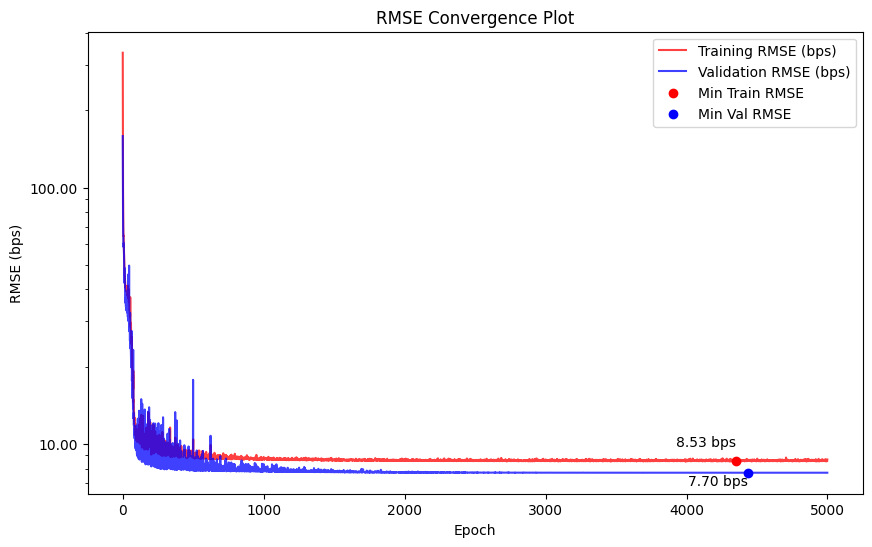

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# Convert RMSE values to basis points (bps)
train_losses_bps = [loss * 10_000 for loss in train_losses]
val_losses_bps = [loss * 10_000 for loss in val_losses]

# Find min RMSE values in basis points and corresponding epochs
min_train_rmse_bps = min(train_losses_bps)
min_train_epoch = train_losses_bps.index(min_train_rmse_bps)

min_val_rmse_bps = min(val_losses_bps)
min_val_epoch = val_losses_bps.index(min_val_rmse_bps)

# Plot RMSE convergence
plt.figure(figsize=(10, 6))
plt.plot(range(epochs), train_losses_bps, label='Training RMSE (bps)', alpha=0.75, color = "red")
plt.plot(range(epochs), val_losses_bps, label='Validation RMSE (bps)', alpha=0.75, color = "blue")

# Highlight min points
plt.scatter(min_train_epoch, min_train_rmse_bps, color='red', zorder=3, label='Min Train RMSE')
plt.scatter(min_val_epoch, min_val_rmse_bps, color='blue', zorder=3, label='Min Val RMSE')

# Annotate min points with their values in basis points
plt.text(min_train_epoch, min_train_rmse_bps + 1, f"{min_train_rmse_bps:.2f} bps", 
         verticalalignment='bottom', horizontalalignment='right', fontsize=10, color='black')

plt.text(min_val_epoch, min_val_rmse_bps - 1, f"{min_val_rmse_bps:.2f} bps", 
         verticalalignment='bottom', horizontalalignment='right', fontsize=10, color='black')

plt.xlabel('Epoch')
plt.ylabel('RMSE (bps)')
plt.yscale('log')
plt.gca().yaxis.set_major_formatter(mticker.FormatStrFormatter("%.2f"))
plt.title('RMSE Convergence Plot')
plt.legend()
#plt.ylim(5, 500)
#plt.yticks([10, 100])
plt.show()

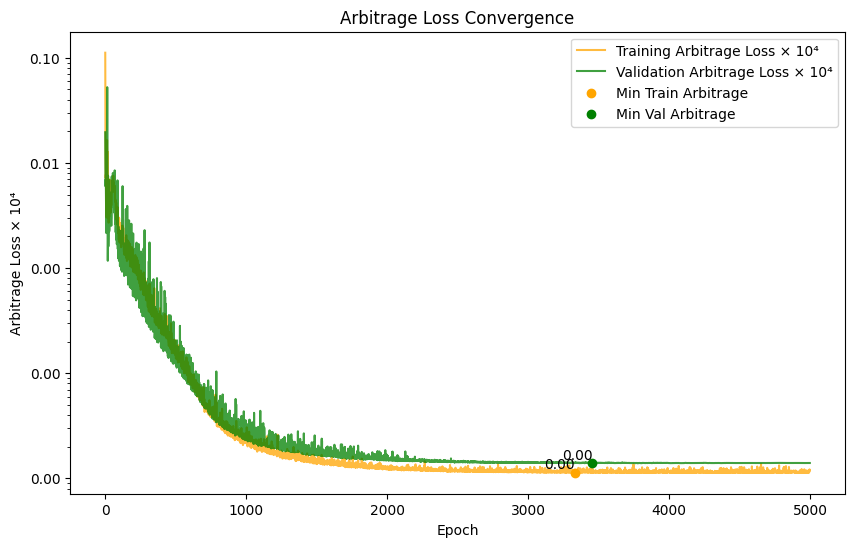

In [ ]:
train_arbitrage_bps = [loss * 10_000 for loss in train_arbitrage]
val_arbitrage_bps = [loss * 10_000 for loss in val_arbitrage]

# Find min arbitrage loss and corresponding epochs
min_train_arb = min(train_arbitrage_bps)
min_train_epoch = train_arbitrage_bps.index(min_train_arb)

min_val_arb = min(val_arbitrage_bps)
min_val_epoch = val_arbitrage_bps.index(min_val_arb)

# Plot arbitrage loss convergence
plt.figure(figsize=(10, 6))
plt.plot(range(epochs), train_arbitrage_bps, label='Training Arbitrage Loss × 10⁴', alpha=0.75, color='orange')
plt.plot(range(epochs), val_arbitrage_bps, label='Validation Arbitrage Loss × 10⁴', alpha=0.75, color='green')

# Highlight min points
plt.scatter(min_train_epoch, min_train_arb, color='orange', zorder=3, label='Min Train Arbitrage')
plt.scatter(min_val_epoch, min_val_arb, color='green', zorder=3, label='Min Val Arbitrage')

# Annotate min points with their values
plt.text(min_train_epoch, min_train_arb * 1.02, f"{min_train_arb:.2f}", 
         verticalalignment='bottom', horizontalalignment='right', fontsize=10, color='black')

plt.text(min_val_epoch, min_val_arb * 1.02, f"{min_val_arb:.2f}", 
         verticalalignment='bottom', horizontalalignment='right', fontsize=10, color='black')

plt.xlabel('Epoch')
plt.ylabel('Arbitrage Loss × 10⁴')
plt.yscale('log')
plt.gca().yaxis.set_major_formatter(mticker.FormatStrFormatter("%.2f"))
plt.title('Arbitrage Loss Convergence')
plt.legend()
plt.show()

In [ ]:
model.eval()

# Load full data
data_full = pd.read_csv('data_2_full.csv', parse_dates=['Date'])

# Filter for test set
test_df = data_full[data_full['Date'].dt.year.isin([2023, 2024])].copy()

# Define function to compute RMSE and Arbitrage Loss
def compute_metrics(model, data_tensor):
    model.eval()
    forward_rates, discount_factors, swap_rates, _, z, taus, mu_total, sigma1, sigma2, rho, short_rate = model(data_tensor)

    z = z.detach().requires_grad_(True)
    B = z.shape[0]

    z_repeated = z.unsqueeze(1).repeat(1, 31, 1)
    decoder_input = torch.cat([z_repeated, taus.unsqueeze(-1)], dim=-1)

    hidden = model.activation(model.decoder_hidden(decoder_input))
    forward_rates_manual = model.decoder_output(hidden).squeeze(-1)

    gradients_latent = torch.autograd.grad(
        outputs=forward_rates_manual,
        inputs=z_repeated,
        grad_outputs=torch.ones_like(forward_rates_manual),
        create_graph=False,
        retain_graph=False
    )[0]

    G_hidden_out = model.G_activation(model.G_hidden(z))
    G_out = model.G_output(G_hidden_out)
    sigma1 = torch.exp(G_out[:, 0])
    sigma2 = torch.exp(G_out[:, 1])
    rho = torch.tanh(G_out[:, 2])

    sigma_matrix = torch.zeros(B, 2, 2, device=z.device)
    sigma_matrix[:, 0, 0] = sigma1
    sigma_matrix[:, 1, 0] = rho * sigma2
    sigma_matrix[:, 1, 1] = sigma2 * torch.sqrt(1 - rho**2)

    sigma_f = torch.einsum('bnd,bdm->bnm', gradients_latent, sigma_matrix.transpose(1, 2))
    sigma_f_left = sigma_f[:, :-1, :]
    sigma_f_right = sigma_f[:, 1:, :]
    delta = taus[0, 1] - taus[0, 0]
    sigma_f_integrals = 0.5 * (sigma_f_left + sigma_f_right) * delta
    sigma_f_int = torch.cumsum(torch.cat([torch.zeros(B, 1, 2, device=z.device), sigma_f_integrals], dim=1), dim=1)

    hjm_term = torch.einsum('bni,bni->bn', sigma_f[:, 1:, :], sigma_f_int[:, 1:, :])
    abs_drift_violation = torch.mean(torch.abs(mu_total - hjm_term)).item() * 10_000

    target = data_tensor
    pred = swap_rates[:, [0, 1, 2, 4, 9, 14, 19, 29]]
    rmse_bps = nn.functional.mse_loss(pred, target).sqrt().item() * 10_000

    return rmse_bps, abs_drift_violation

currency_metrics = []
for currency in currencies.unique():
    currency_train_tensor = torch.tensor(
        train_df.loc[currencies == currency].values, dtype=torch.float32
    )
    currency_val_tensor = torch.tensor(
        val_df.loc[currencies == currency].values, dtype=torch.float32
    )
    currency_test_tensor = torch.tensor(
        test_df[test_df['Currency'] == currency].iloc[:, 2:].values, dtype=torch.float32
    )

    train_rmse, train_arbitrage = compute_metrics(model, currency_train_tensor)
    val_rmse, val_arbitrage = compute_metrics(model, currency_val_tensor)
    if currency_test_tensor.shape[0] == 0:
        print(f"Skipping {currency}: no test data available.")
        test_rmse, test_arbitrage = float('nan'), float('nan')
    else:
        test_rmse, test_arbitrage = compute_metrics(model, currency_test_tensor)

    currency_metrics.append({
        "Currency": currency,
        "Train RMSE (bps)": train_rmse,
        "Validation RMSE (bps)": val_rmse,
        "Test RMSE (bps)": test_rmse,
        "Train Arbitrage Loss": train_arbitrage,
        "Validation Arbitrage Loss": val_arbitrage,
        "Test Arbitrage Loss": test_arbitrage
    })

rmse_df = pd.DataFrame(currency_metrics)
rmse_df.loc[len(rmse_df)] = [
    "Average",
    rmse_df["Train RMSE (bps)"].mean(),
    rmse_df["Validation RMSE (bps)"].mean(),
    rmse_df["Test RMSE (bps)"].mean(),
    rmse_df["Train Arbitrage Loss"].mean(),
    rmse_df["Validation Arbitrage Loss"].mean(),
    rmse_df["Test Arbitrage Loss"].mean()
]

print(rmse_df.to_string(index=False))

Skipping GBP: no test data available.
Currency  Train RMSE (bps)  Validation RMSE (bps)  Test RMSE (bps)  Train Arbitrage Loss  Validation Arbitrage Loss  Test Arbitrage Loss
     AUD          9.205386               8.281200        13.462055              0.004236                   0.002784             0.006057
     CAD          8.941446               8.371055        29.507999              0.001469                   0.001191             0.251512
     DKK          7.952597               4.456220        16.184092              0.032140                   0.000782             0.097836
     EUR          7.962690               5.757251        17.438537              0.023449                   0.089704             0.663927
     GBP          8.931700               9.321537              NaN              0.031042                   0.051419                  NaN
     JPY          8.808148               8.165205         3.405921              0.207742                   0.207267             0.000498
   

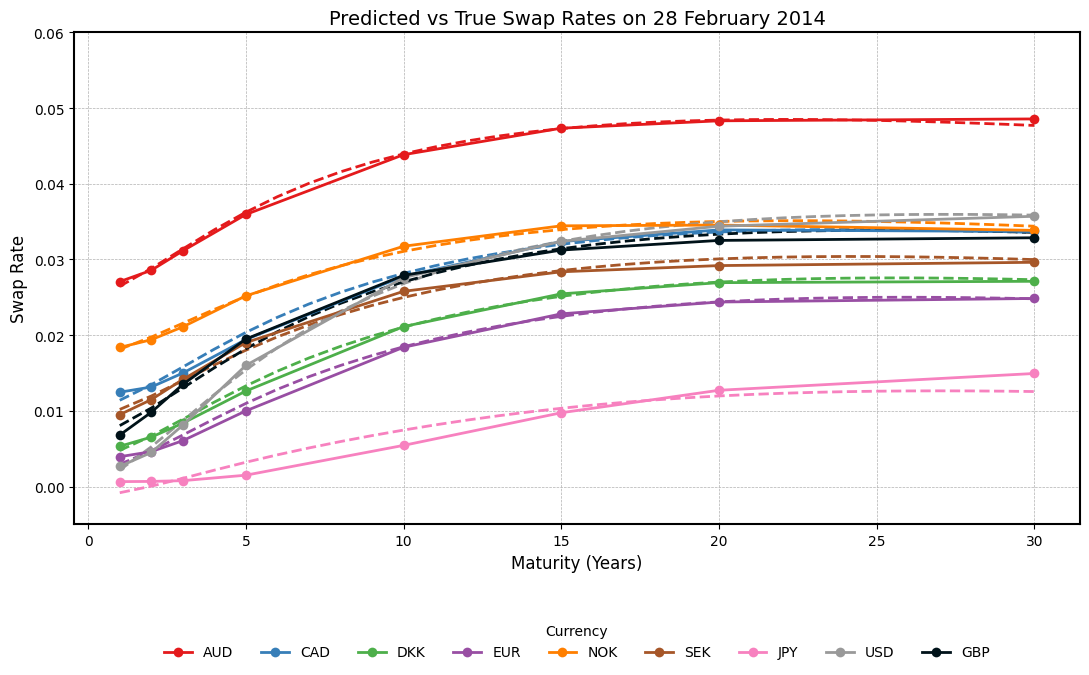

In [ ]:
# Unpack train and validation tensors, dates, and currencies
train_tensor, train_dates_np, train_currencies_np = train_data_with_dates_currencies
val_tensor, val_dates_np, val_currencies_np = val_data_with_dates_currencies

# Filter for target date
target_date = np.datetime64("2014-02-28")
date_filter_train = train_dates_np == target_date
date_filter_val = val_dates_np == target_date

selected_train_data = train_tensor[date_filter_train]
selected_val_data = val_tensor[date_filter_val]

selected_train_currencies = train_currencies_np[date_filter_train]
selected_val_currencies = val_currencies_np[date_filter_val]

# Combine data
selected_data = torch.cat((selected_train_data, selected_val_data), dim=0)
selected_currencies = np.concatenate((selected_train_currencies, selected_val_currencies))

# Get predictions
model.eval()
forward_rates, discount_factors, swap_rates_pred, drift_consistency, z, taus, mu_total, sigma1, sigma2, rho, short_rate = model(selected_data)

# Define maturities
selected_maturities = [1, 2, 3, 5, 10, 15, 20, 30]
full_maturities = list(range(1, 31))

plot_data = []
for i, currency in enumerate(selected_currencies):
    true_row = selected_data[i].cpu().numpy()
    pred_row = swap_rates_pred[i]

    for m_idx, m in enumerate(selected_maturities):
        plot_data.append({"Maturity": m, "Rate": true_row[m_idx], "Currency": currency, "Type": "True"})
    for m in range(1, 31):
        plot_data.append({"Maturity": m, "Rate": pred_row[m-1].item(), "Currency": currency, "Type": "Predicted"})

df_plot = pd.DataFrame(plot_data)

legend_order = ['AUD', 'CAD', 'DKK', 'EUR', 'NOK', 'SEK', 'JPY', 'USD', "GBP"]
custom_palette = {
    'AUD': "#E41A1C", 'CAD': "#377EB8", 'DKK': "#4DAF4A", 'EUR': "#984EA3",
    'NOK': "#FF7F00", 'SEK': "#A65628", 'JPY': "#F781BF", 'USD': "#999999", "GBP": "#001219"
}

plt.figure(figsize=(11, 7))

sns.lineplot(
    data=df_plot[df_plot["Type"] == "Predicted"],
    x="Maturity", y="Rate",
    hue="Currency",
    hue_order=legend_order,
    palette=custom_palette,
    linewidth=2,
    linestyle="--",
    legend=False
)

true_lines = sns.lineplot(
    data=df_plot[df_plot["Type"] == "True"],
    x="Maturity", y="Rate",
    hue="Currency",
    hue_order=legend_order,
    palette=custom_palette,
    linewidth=2,
    marker='o'
)

for line in true_lines.lines:
    if line.get_marker() != 'None':
        line.set_markersize(7)
        line.set_markerfacecolor(line.get_color())
        line.set_markeredgewidth(0)

plt.xticks(ticks=range(0, 31, 5))
plt.yticks(ticks=np.arange(-0.01, 0.061, 0.01))
plt.ylim(-0.005, 0.06)

plt.title("Predicted vs True Swap Rates on 28 February 2014", fontsize=14, ha="center")
plt.xlabel("Maturity (Years)", fontsize=12)
plt.ylabel("Swap Rate", fontsize=12)

plt.legend(
    title="Currency",
    loc="lower center",
    bbox_to_anchor=(0.5, -0.3),
    ncol=9,
    frameon=False
)

plt.grid(True, linestyle="--", linewidth=0.5)
for spine in plt.gca().spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1.5)

plt.tight_layout()
plt.show()

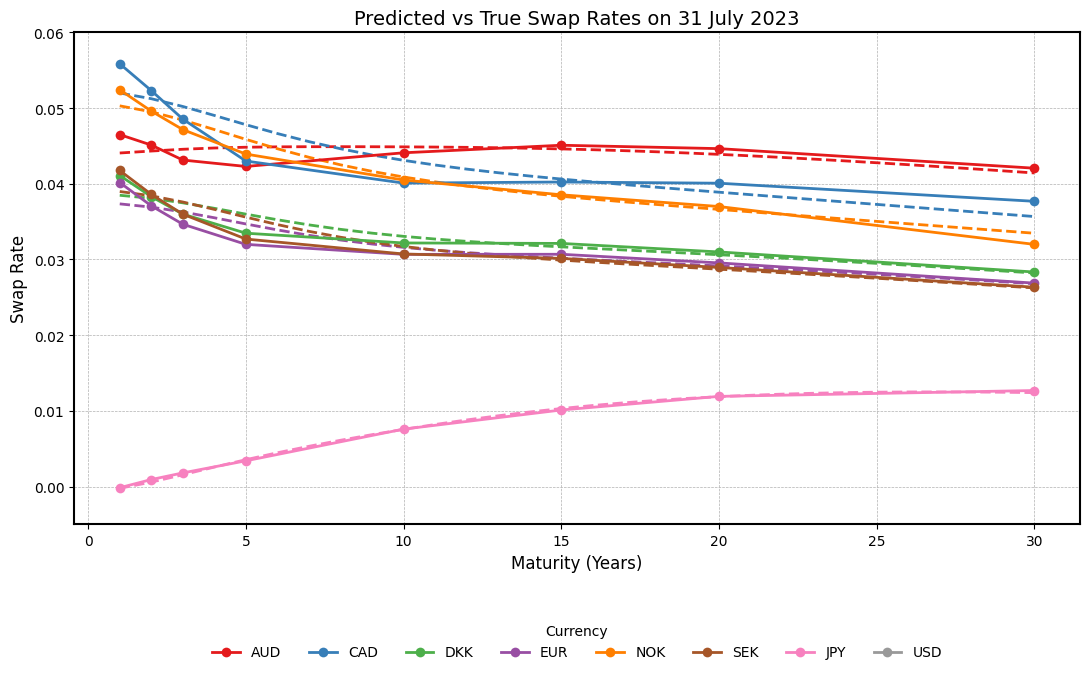

In [ ]:
plot_date = pd.to_datetime("2023-07-31")
data_full["Date"] = pd.to_datetime(data_full["Date"])
filtered_data = data_full[data_full["Date"] == plot_date].copy()

maturity_cols = ['1Y', '2Y', '3Y', '5Y', '10Y', '15Y', '20Y', '30Y']
filtered_data_tensor = torch.tensor(filtered_data[maturity_cols].values, dtype=torch.float32)
filtered_currencies = filtered_data["Currency"].values

model.eval()
forward_rates, discount_factors, predicted_swaps, drift_consistency, z, taus, mu_total, sigma1, sigma2, rho, short_rate = model(filtered_data_tensor)

plot_data = []
for i, currency in enumerate(filtered_currencies):
    true_row = filtered_data_tensor[i].numpy()
    pred_row = predicted_swaps[i]
    for m_idx, (maturity, true_rate) in enumerate(zip(maturity_cols, true_row)):
        plot_data.append({"Maturity": int(maturity.rstrip("Y")), "Rate": true_rate, "Currency": currency, "Type": "True"})
    for m in range(1, 31):
        plot_data.append({"Maturity": m, "Rate": pred_row[m-1].item(), "Currency": currency, "Type": "Predicted"})

df_plot = pd.DataFrame(plot_data)

legend_order = ['AUD', 'CAD', 'DKK', 'EUR', 'NOK', 'SEK', 'JPY', 'USD', 'USD']
custom_palette = {
    'AUD': "#E41A1C",
    'CAD': "#377EB8",
    'DKK': "#4DAF4A",
    'EUR': "#984EA3",
    'NOK': "#FF7F00",
    'SEK': "#A65628",
    'JPY': "#F781BF",
    'USD': "#999999",  
}

plt.figure(figsize=(11, 7))

sns.lineplot(
    data=df_plot[df_plot["Type"] == "Predicted"],
    x="Maturity", y="Rate",
    hue="Currency",
    hue_order=legend_order,
    palette=custom_palette,
    linewidth=2,
    linestyle='--',
    legend=False
)

lineplot = sns.lineplot(
    data=df_plot[df_plot["Type"] == "True"],
    x="Maturity", y="Rate",
    hue="Currency",
    hue_order=legend_order,
    palette=custom_palette,
    linewidth=2,
    marker='o'
)

for line in lineplot.lines:
    if line.get_marker() != 'None':
        line.set_markersize(7)                     
        line.set_markerfacecolor(line.get_color())
        line.set_markeredgewidth(0)       


plt.xticks(ticks=range(0, 31, 5))
plt.yticks(ticks=np.arange(-0.01, 0.061, 0.01))
plt.ylim(-0.005, 0.06)

plt.title("Predicted vs True Swap Rates on 31 July 2023", fontsize=14, ha="center")
plt.xlabel("Maturity (Years)", fontsize=12)
plt.ylabel("Swap Rate", fontsize=12)

plt.legend(
    title="Currency",
    loc="lower center",
    bbox_to_anchor=(0.5, -0.3),
    ncol=8,
    frameon=False
)

plt.grid(True, linestyle="--", linewidth=0.5)
for spine in plt.gca().spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1.5)

plt.tight_layout()
plt.show()

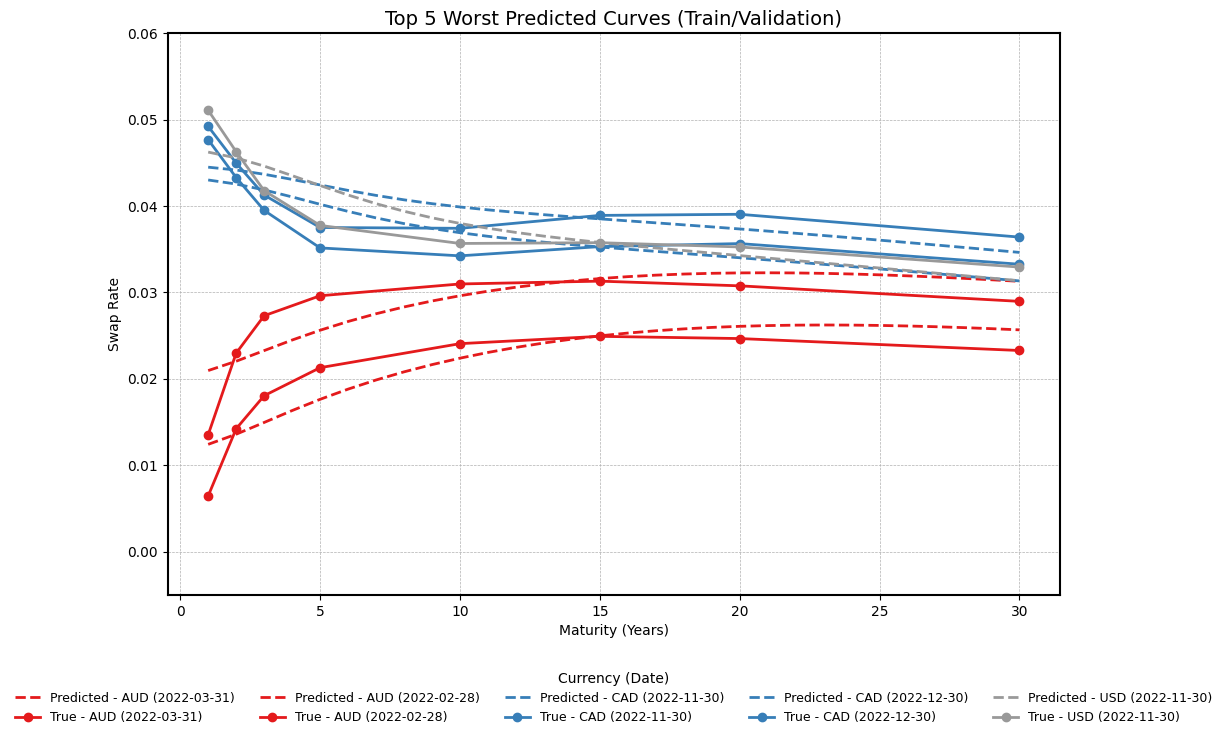

In [ ]:
marker_styles = ['o', 's', '^', 'D', 'v', 'P', '*', 'X', '<', '>']

selected_indices = [0, 1, 2, 4, 9, 14, 19, 29]
selected_maturities = [1, 2, 3, 5, 10, 15, 20, 30]
full_maturities = list(range(1, 31))

custom_palette = {
    'AUD': "#E41A1C", 'CAD': "#377EB8", 'DKK': "#4DAF4A", 'EUR': "#984EA3",
    'NOK': "#FF7F00", 'SEK': "#A65628", 'JPY': "#F781BF", 'USD': "#999999", "GBP": "#001219"
}
fallback_color = "#000000"

train_val_tensor = torch.cat((train_tensor, val_tensor), dim=0)
train_val_dates = np.concatenate((train_dates_np, val_dates_np))
train_val_currencies = np.concatenate((train_currencies_np, val_currencies_np))

model.eval()
forward_rates, discount_factors, swap_rates_pred, drift_consistency, z, taus, mu_total, sigma1, sigma2, rho, short_rate = model(train_val_tensor)
selected_pred = swap_rates_pred[:, selected_indices]
rmse_per_curve = torch.sqrt(torch.mean((selected_pred - train_val_tensor) ** 2, dim=1))

worst_indices = torch.topk(rmse_per_curve, 5).indices.cpu().numpy()

plt.figure(figsize=(12, 8))

for idx in worst_indices:
    currency = train_val_currencies[idx]
    date = pd.to_datetime(train_val_dates[idx]).strftime('%Y-%m-%d')
    color = custom_palette.get(currency, fallback_color)
    label = f"{currency} ({date})"

    true_curve = train_val_tensor[idx].numpy()
    pred_curve = swap_rates_pred[idx].cpu().detach().numpy()

    plt.plot(full_maturities, pred_curve, linestyle="--", linewidth=2, color=color, label=f"Predicted - {label}")
    plt.plot(selected_maturities, true_curve, marker='o', linewidth=2, color=color, label=f"True - {label}")
    # Annotate last point (30Y) of true curve
    #plt.text(
    #    x=selected_maturities[-1] + 0.4,
    #    y=true_curve[-1],
    #    s=label,
     #   fontsize=9,
    #    color=color,
    #    verticalalignment='center'
    #)


plt.title("Top 5 Worst Predicted Curves (Train/Validation)", fontsize=14)
plt.xlabel("Maturity (Years)")
plt.ylabel("Swap Rate")
plt.xticks(range(0, 31, 5))
plt.yticks(np.arange(-0.01, 0.061, 0.01))
plt.ylim(-0.005, 0.06)
plt.grid(True, linestyle="--", linewidth=0.5)

for spine in plt.gca().spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1.5)

plt.legend(
    title="Currency (Date)",
    loc="lower center",
    bbox_to_anchor=(0.5, -0.25),
    ncol=5,
    frameon=False,
    fontsize=9,
    title_fontsize=10
)
plt.tight_layout()
plt.subplots_adjust(bottom=0.25)
plt.show()

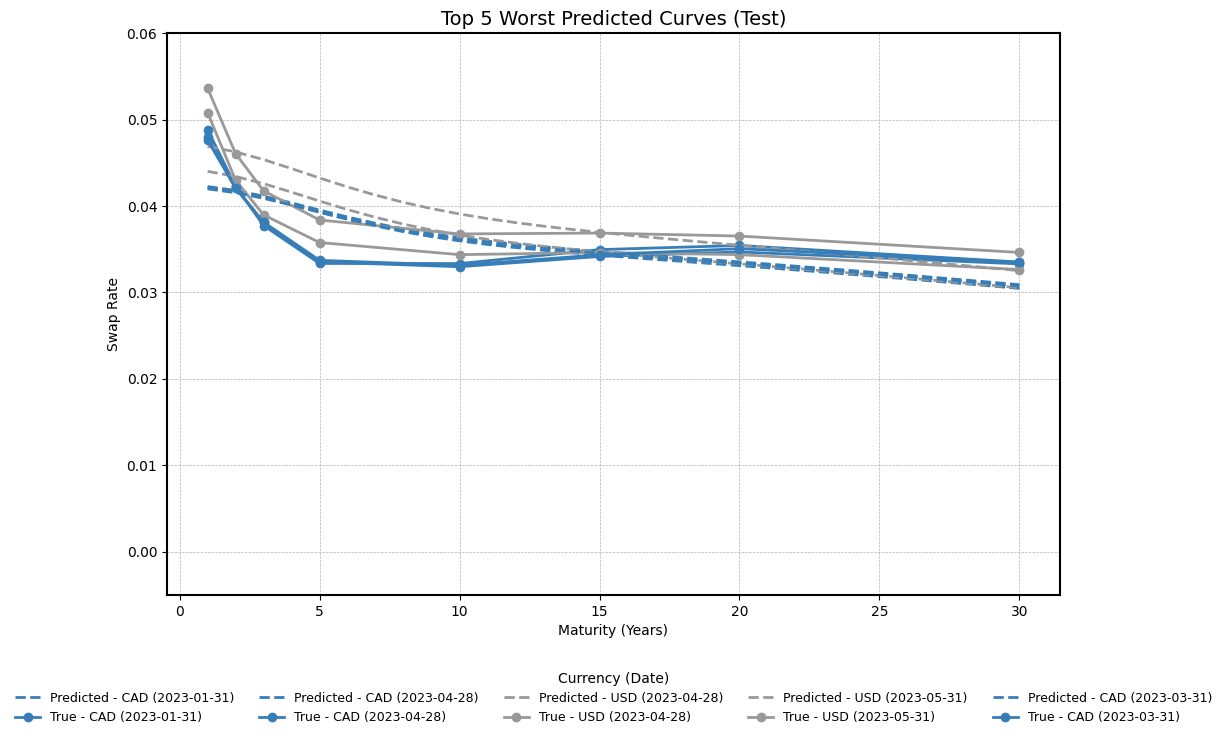

In [ ]:
data_full = pd.read_csv('data_2_full.csv', parse_dates=['Date'])
test_df = data_full[data_full['Date'].dt.year.isin([2023, 2024])].copy()
test_tensor = torch.tensor(test_df.iloc[:, 2:].values, dtype=torch.float32)
test_currencies = test_df["Currency"].values
test_dates = test_df["Date"].values

selected_indices = [0, 1, 2, 4, 9, 14, 19, 29]
selected_maturities = [1, 2, 3, 5, 10, 15, 20, 30]
full_maturities = list(range(1, 31))

custom_palette = {
    'AUD': "#E41A1C", 'CAD': "#377EB8", 'DKK': "#4DAF4A", 'EUR': "#984EA3",
    'NOK': "#FF7F00", 'SEK': "#A65628", 'JPY': "#F781BF", 'USD': "#999999", "GBP": "#001219"
}
fallback_color = "#000000"

model.eval()
forward_rates, discount_factors, swap_rates_pred, drift_consistency, z, taus, mu_total, sigma1, sigma2, rho, short_rate = model(test_tensor)
selected_pred = swap_rates_pred[:, selected_indices]
rmse_per_curve = torch.sqrt(torch.mean((selected_pred - test_tensor) ** 2, dim=1))

worst_indices = torch.topk(rmse_per_curve, 5).indices.cpu().numpy()

plt.figure(figsize=(12, 8))

for idx in worst_indices:
    currency = test_currencies[idx]
    date = pd.to_datetime(test_dates[idx]).strftime('%Y-%m-%d')
    color = custom_palette.get(currency, fallback_color)
    label = f"{currency} ({date})"

    true_curve = test_tensor[idx].numpy()
    pred_curve = swap_rates_pred[idx].cpu().detach().numpy()

    plt.plot(full_maturities, pred_curve, linestyle="--", linewidth=2, color=color, label=f"Predicted - {label}")
    plt.plot(selected_maturities, true_curve, marker='o', linewidth=2, color=color, label=f"True - {label}")

plt.title("Top 5 Worst Predicted Curves (Test)", fontsize=14)
plt.xlabel("Maturity (Years)")
plt.ylabel("Swap Rate")
plt.xticks(range(0, 31, 5))
plt.yticks(np.arange(-0.01, 0.061, 0.01))
plt.ylim(-0.005, 0.06)
plt.grid(True, linestyle="--", linewidth=0.5)

for spine in plt.gca().spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1.5)

plt.legend(
    title="Currency (Date)",
    loc="lower center",
    bbox_to_anchor=(0.5, -0.25),
    ncol=5,
    frameon=False,
    fontsize=9,
    title_fontsize=10
)

plt.tight_layout()
plt.subplots_adjust(bottom=0.25)
plt.show()

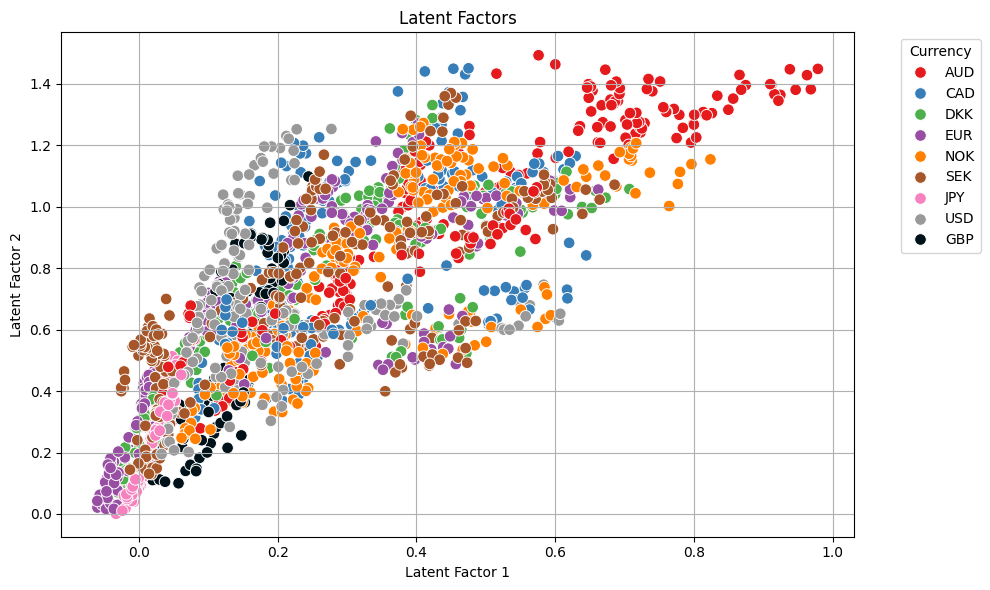

In [ ]:
data_full = pd.read_csv("data_2_full.csv", parse_dates=["Date"])
maturity_cols = ['1Y', '2Y', '3Y', '5Y', '10Y', '15Y', '20Y', '30Y']

train_df = data_full[data_full["Date"].dt.year <= 2018].copy()
val_df = data_full[(data_full["Date"].dt.year > 2018) & (data_full["Date"].dt.year < 2023)].copy()
test_df = data_full[data_full["Date"].dt.year >= 2023].copy()

train_df["Set"] = "Train"
val_df["Set"] = "Validation"
test_df["Set"] = "Test"
combined_df = pd.concat([train_df, val_df, test_df])

data_tensor = torch.tensor(combined_df[maturity_cols].values, dtype=torch.float32)
currencies = combined_df["Currency"].values
sets = combined_df["Set"].values

model.eval()
forward_rates, discount_factors, swap_rates_pred, drift_consistency, z, taus, mu_total, sigma1, sigma2, rho, short_rate = model(data_tensor)

legend_order = ['AUD', 'CAD', 'DKK', 'EUR', 'NOK', 'SEK', 'JPY', 'USD', "GBP"]
custom_palette = {
    'AUD': "#E41A1C", 'CAD': "#377EB8", 'DKK': "#4DAF4A", 'EUR': "#984EA3",
    'NOK': "#FF7F00", 'SEK': "#A65628", 'JPY': "#F781BF", 'USD': "#999999", "GBP": "#001219"
}

latent_df = pd.DataFrame({
    "Latent_1": z[:, 0].detach().numpy(),
    "Latent_2": z[:, 1].detach().numpy(),
    "Currency": currencies,
    "Set": sets
})

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=latent_df,
    x="Latent_1", y="Latent_2",
    hue="Currency",
    hue_order=legend_order,
    palette=custom_palette,
    s=70
)
plt.title("Latent Factors")
plt.xlabel("Latent Factor 1")
plt.ylabel("Latent Factor 2")
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Currency")
plt.tight_layout()
plt.show()

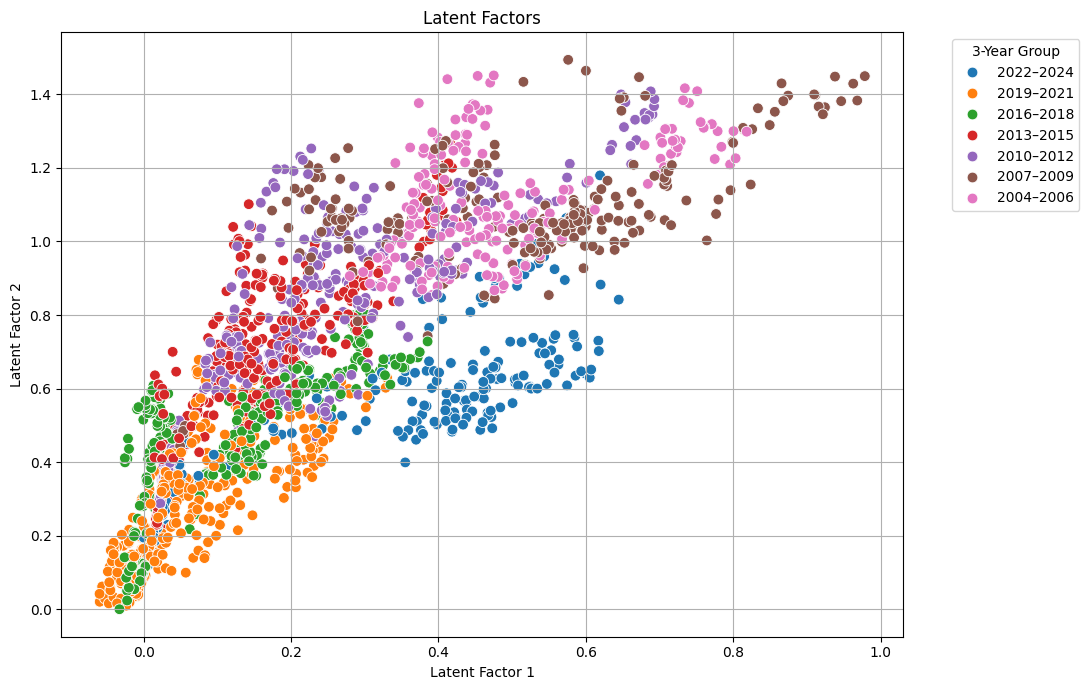

In [ ]:
data_full = pd.read_csv("data_2_full.csv", parse_dates=["Date"])
maturity_cols = ['1Y', '2Y', '3Y', '5Y', '10Y', '15Y', '20Y', '30Y']
data_full["Year"] = data_full["Date"].dt.year

data_filtered = data_full[data_full["Year"].between(2004, 2024)].copy()

def label_year_group(year):
    base = (year - 2004) // 3 * 3 + 2004
    return f"{base}–{base+2}"

data_filtered["YearGroup"] = data_filtered["Year"].apply(label_year_group)

data_tensor = torch.tensor(data_filtered[maturity_cols].values, dtype=torch.float32)
currencies = data_filtered["Currency"].values
year_groups = data_filtered["YearGroup"].values

model.eval()
forward_rates, discount_factors, swap_rates, drift_consistency, z, taus, mu_total, sigma1, sigma2, rho, short_rate = model(data_tensor)

latent_df = pd.DataFrame({
    "Latent_1": z[:, 0].detach().numpy(),
    "Latent_2": z[:, 1].detach().numpy(),
    "Currency": currencies,
    "YearGroup": year_groups
})

plt.figure(figsize=(11, 7))
sns.scatterplot(
    data=latent_df, x="Latent_1", y="Latent_2",
    hue="YearGroup", palette="tab10", s=60
)
plt.title("Latent Factors")
plt.xlabel("Latent Factor 1")
plt.ylabel("Latent Factor 2")
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="3-Year Group")
plt.tight_layout()
plt.show()

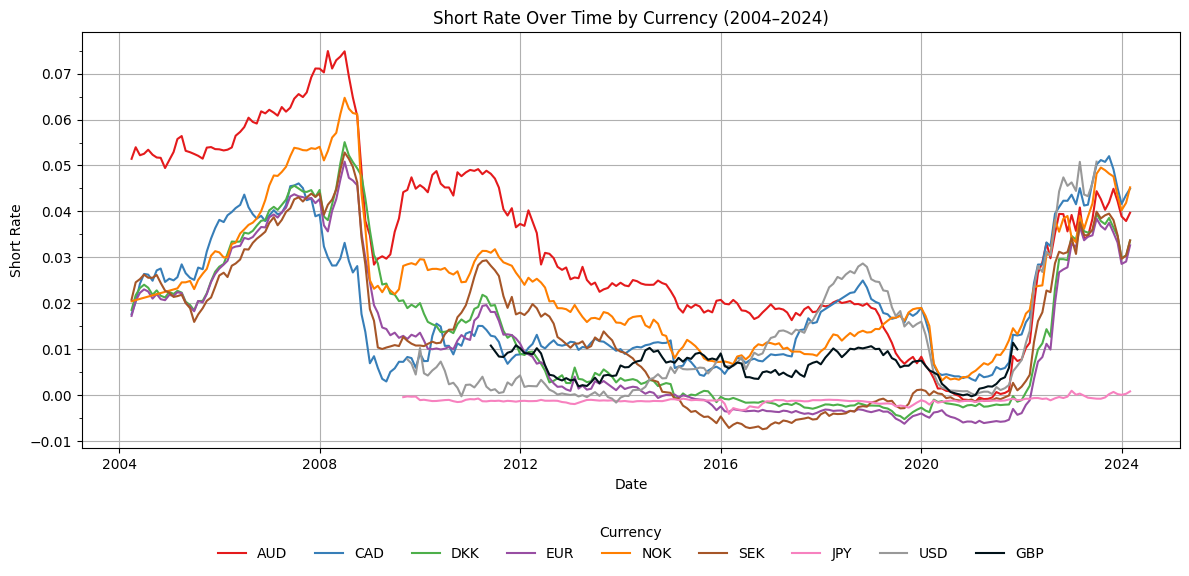

In [ ]:
legend_order = ['AUD', 'CAD', 'DKK', 'EUR', 'NOK', 'SEK', 'JPY', 'USD', "GBP"]
custom_palette = {
    'AUD': "#E41A1C", 'CAD': "#377EB8", 'DKK': "#4DAF4A", 'EUR': "#984EA3",
    'NOK': "#FF7F00", 'SEK': "#A65628", 'JPY': "#F781BF", 'USD': "#999999", "GBP": "#001219"
}

data_full = pd.read_csv("data_2_full.csv", parse_dates=["Date"])
maturity_cols = ['1Y', '2Y', '3Y', '5Y', '10Y', '15Y', '20Y', '30Y']
data_full["Year"] = data_full["Date"].dt.year
data_filtered = data_full[data_full["Year"].between(2004, 2024)].copy()

x_tensor = torch.tensor(data_filtered[maturity_cols].values, dtype=torch.float32)
dates = data_filtered["Date"].values
currencies = data_filtered["Currency"].values

model.eval()
forward_rates, discount_factors, swap_rates, drift_consistency, z, taus, mu_total, sigma1, sigma2, rho, short_rate = model(x_tensor)
short_rates = short_rate.cpu().detach().numpy()

df_risk_neutral = pd.DataFrame({
    "Date": dates,
    "Currency": currencies,
    "RiskNeutralRate": short_rates
})

plt.close('all')
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=df_risk_neutral,
    x="Date",
    y="RiskNeutralRate",
    hue="Currency",
    hue_order=legend_order,
    palette=custom_palette
)
plt.title("Short Rate Over Time by Currency (2004–2024)")
plt.xlabel("Date")
plt.ylabel("Short Rate")
plt.grid(True)

ax = plt.gca()
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.01))  
ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.005)) 

plt.legend(
    title="Currency",
    loc="lower center",
    bbox_to_anchor=(0.5, -0.3),
    ncol=9,
    frameon=False
)

plt.tight_layout()
plt.show()

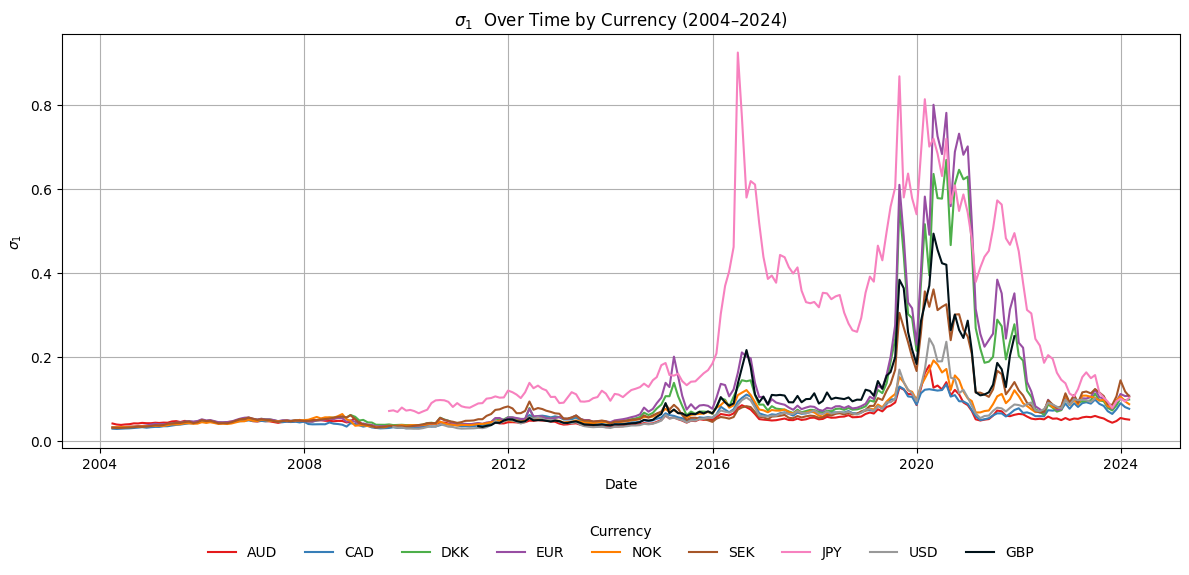

In [ ]:
legend_order = ['AUD', 'CAD', 'DKK', 'EUR', 'NOK', 'SEK', 'JPY', 'USD', "GBP"]
custom_palette = {
    'AUD': "#E41A1C", 'CAD': "#377EB8", 'DKK': "#4DAF4A", 'EUR': "#984EA3",
    'NOK': "#FF7F00", 'SEK': "#A65628", 'JPY': "#F781BF", 'USD': "#999999", "GBP": "#001219"
}

data_full = pd.read_csv("data_2_full.csv", parse_dates=["Date"])
maturity_cols = ['1Y', '2Y', '3Y', '5Y', '10Y', '15Y', '20Y', '30Y']
data_full["Year"] = data_full["Date"].dt.year
data_filtered = data_full[data_full["Year"].between(2004, 2024)].copy()

x_tensor = torch.tensor(data_filtered[maturity_cols].values, dtype=torch.float32)
dates = data_filtered["Date"].values
currencies = data_filtered["Currency"].values

model.eval()
forward_rates, discount_factors, swap_rates, drift_consistency, z, taus, mu_total, sigma1, sigma2, rho, short_rate = model(x_tensor)
sigma1_at_short_maturity = sigma1.detach().cpu().numpy()

df_risk_neutral = pd.DataFrame({
    "Date": dates,
    "Currency": currencies,
    "sigma_1": sigma1_at_short_maturity
})

plt.close('all')
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=df_risk_neutral,
    x="Date",
    y="sigma_1",
    hue="Currency",
    hue_order=legend_order,
    palette=custom_palette
)
plt.title(r"$\sigma_1$  Over Time by Currency (2004–2024)")
plt.xlabel("Date")
plt.ylabel(r"$\sigma_1$ ")
plt.grid(True)

plt.legend(
    title="Currency",
    loc="lower center",
    bbox_to_anchor=(0.5, -0.3),
    ncol=9,
    frameon=False
)

plt.tight_layout()
plt.show()

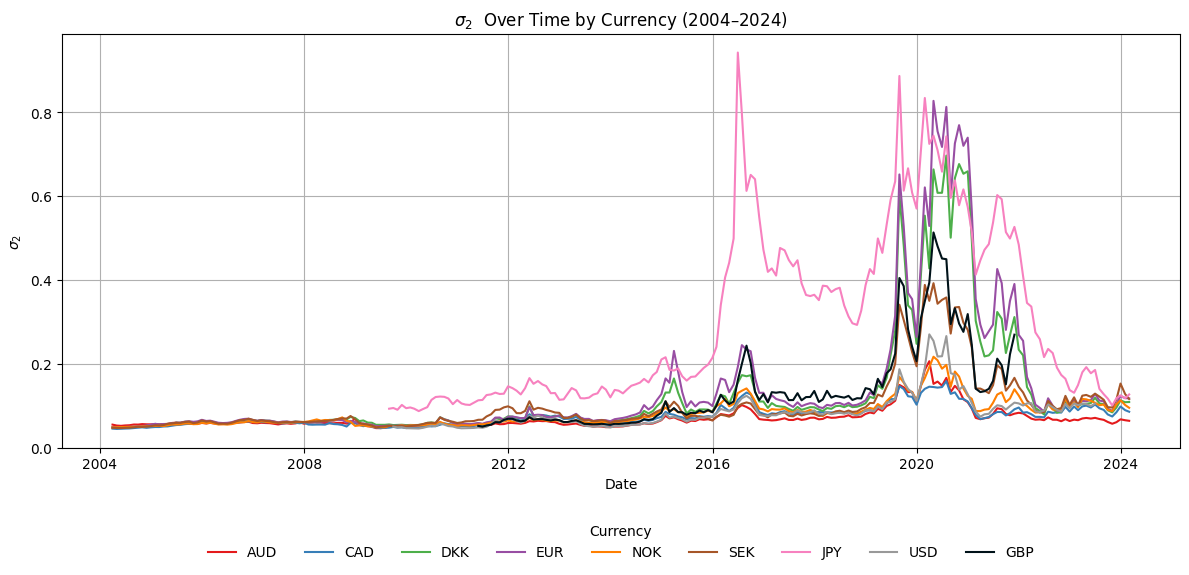

In [ ]:
legend_order = ['AUD', 'CAD', 'DKK', 'EUR', 'NOK', 'SEK', 'JPY', 'USD', "GBP"]
custom_palette = {
    'AUD': "#E41A1C", 'CAD': "#377EB8", 'DKK': "#4DAF4A", 'EUR': "#984EA3",
    'NOK': "#FF7F00", 'SEK': "#A65628", 'JPY': "#F781BF", 'USD': "#999999", "GBP": "#001219"
}

data_full = pd.read_csv("data_2_full.csv", parse_dates=["Date"])
maturity_cols = ['1Y', '2Y', '3Y', '5Y', '10Y', '15Y', '20Y', '30Y']
data_full["Year"] = data_full["Date"].dt.year
data_filtered = data_full[data_full["Year"].between(2004, 2024)].copy()

x_tensor = torch.tensor(data_filtered[maturity_cols].values, dtype=torch.float32)
dates = data_filtered["Date"].values
currencies = data_filtered["Currency"].values

model.eval()
forward_rates, discount_factors, swap_rates, drift_consistency, z, taus, mu_total, sigma1, sigma2, rho, short_rate = model(x_tensor)
sigma2_at_short_maturity = sigma2.detach().cpu().numpy()

df_risk_neutral = pd.DataFrame({
    "Date": dates,
    "Currency": currencies,
    "sigma_2": sigma2_at_short_maturity
})

plt.close('all')
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=df_risk_neutral,
    x="Date",
    y="sigma_2",
    hue="Currency",
    hue_order=legend_order,
    palette=custom_palette
)
plt.title(r"$\sigma_2$  Over Time by Currency (2004–2024)")
plt.xlabel("Date")
plt.ylabel(r"$\sigma_2$ ")
plt.grid(True)

plt.legend(
    title="Currency",
    loc="lower center",
    bbox_to_anchor=(0.5, -0.3),
    ncol=9,
    frameon=False
)

plt.tight_layout()
plt.show()

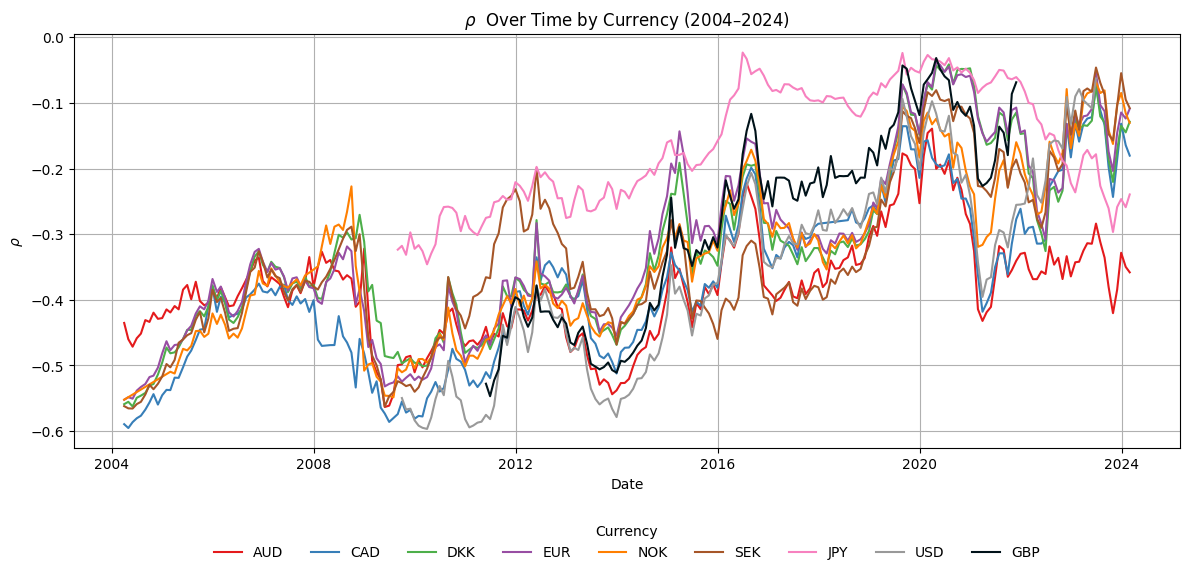

In [ ]:
legend_order = ['AUD', 'CAD', 'DKK', 'EUR', 'NOK', 'SEK', 'JPY', 'USD', "GBP"]
custom_palette = {
    'AUD': "#E41A1C", 'CAD': "#377EB8", 'DKK': "#4DAF4A", 'EUR': "#984EA3",
    'NOK': "#FF7F00", 'SEK': "#A65628", 'JPY': "#F781BF", 'USD': "#999999", "GBP": "#001219"
}

data_full = pd.read_csv("data_2_full.csv", parse_dates=["Date"])
maturity_cols = ['1Y', '2Y', '3Y', '5Y', '10Y', '15Y', '20Y', '30Y']
data_full["Year"] = data_full["Date"].dt.year
data_filtered = data_full[data_full["Year"].between(2004, 2024)].copy()

x_tensor = torch.tensor(data_filtered[maturity_cols].values, dtype=torch.float32)
dates = data_filtered["Date"].values
currencies = data_filtered["Currency"].values

model.eval()
forward_rates, discount_factors, swap_rates, drift_consistency, z, taus, mu_total, sigma1, sigma2, rho, short_rate = model(x_tensor)
rho = rho.detach().cpu().numpy()

df_risk_neutral = pd.DataFrame({
    "Date": dates,
    "Currency": currencies,
    "rho": rho
})

plt.close('all')
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=df_risk_neutral,
    x="Date",
    y="rho",
    hue="Currency",
    hue_order=legend_order,
    palette=custom_palette
)
plt.title(r"$\rho$  Over Time by Currency (2004–2024)")
plt.xlabel("Date")
plt.ylabel(r"$\rho$ ")
plt.grid(True)

plt.legend(
    title="Currency",
    loc="lower center",
    bbox_to_anchor=(0.5, -0.3),
    ncol=9,
    frameon=False
)

plt.tight_layout()
plt.show()

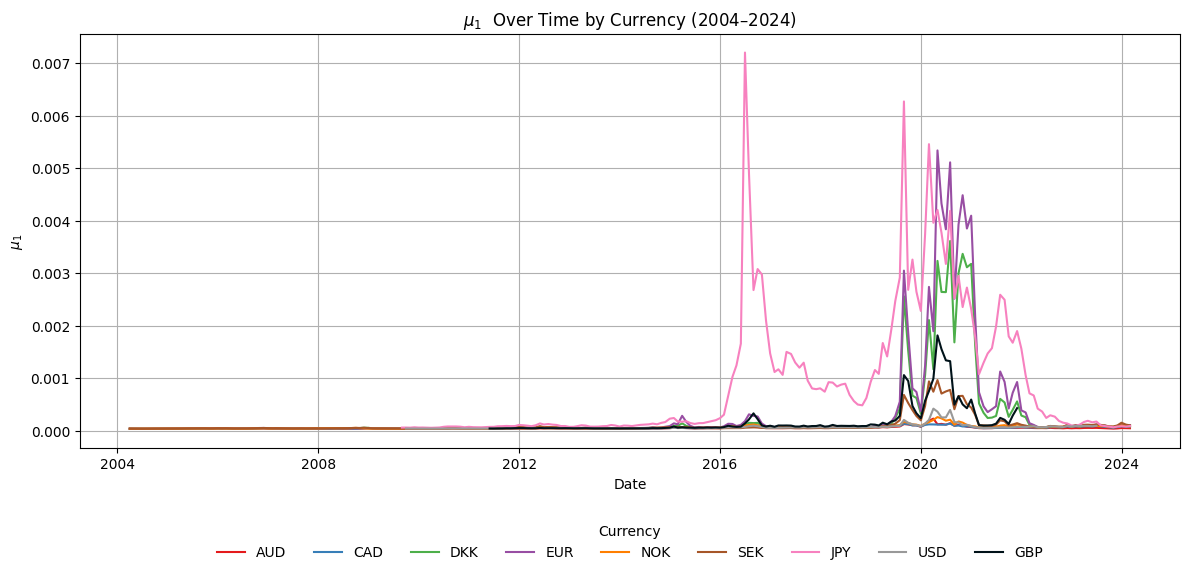

In [ ]:
legend_order = ['AUD', 'CAD', 'DKK', 'EUR', 'NOK', 'SEK', 'JPY', 'USD', "GBP"]
custom_palette = {
    'AUD': "#E41A1C", 'CAD': "#377EB8", 'DKK': "#4DAF4A", 'EUR': "#984EA3",
    'NOK': "#FF7F00", 'SEK': "#A65628", 'JPY': "#F781BF", 'USD': "#999999", "GBP": "#001219"
}

data_full = pd.read_csv("data_2_full.csv", parse_dates=["Date"])
maturity_cols = ['1Y', '2Y', '3Y', '5Y', '10Y', '15Y', '20Y', '30Y']
data_full["Year"] = data_full["Date"].dt.year
data_filtered = data_full[data_full["Year"].between(2004, 2024)].copy()

x_tensor = torch.tensor(data_filtered[maturity_cols].values, dtype=torch.float32)
dates = data_filtered["Date"].values
currencies = data_filtered["Currency"].values

model.eval()
forward_rates, discount_factors, swap_rates, drift_consistency, z, taus, mu_total, sigma1, sigma2, rho, short_rate = model(x_tensor)
mu1 = mu_total[:, 0].detach().cpu().numpy()

df_risk_neutral = pd.DataFrame({
    "Date": dates,
    "Currency": currencies,
    "sigma_1": mu1
})

plt.close('all')
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=df_risk_neutral,
    x="Date",
    y="sigma_1",
    hue="Currency",
    hue_order=legend_order,
    palette=custom_palette
)
plt.title(r"$\mu_1$  Over Time by Currency (2004–2024)")
plt.xlabel("Date")
plt.ylabel(r"$\mu_1$ ")
plt.grid(True)

plt.legend(
    title="Currency",
    loc="lower center",
    bbox_to_anchor=(0.5, -0.3),
    ncol=9,
    frameon=False
)

plt.tight_layout()
plt.show()

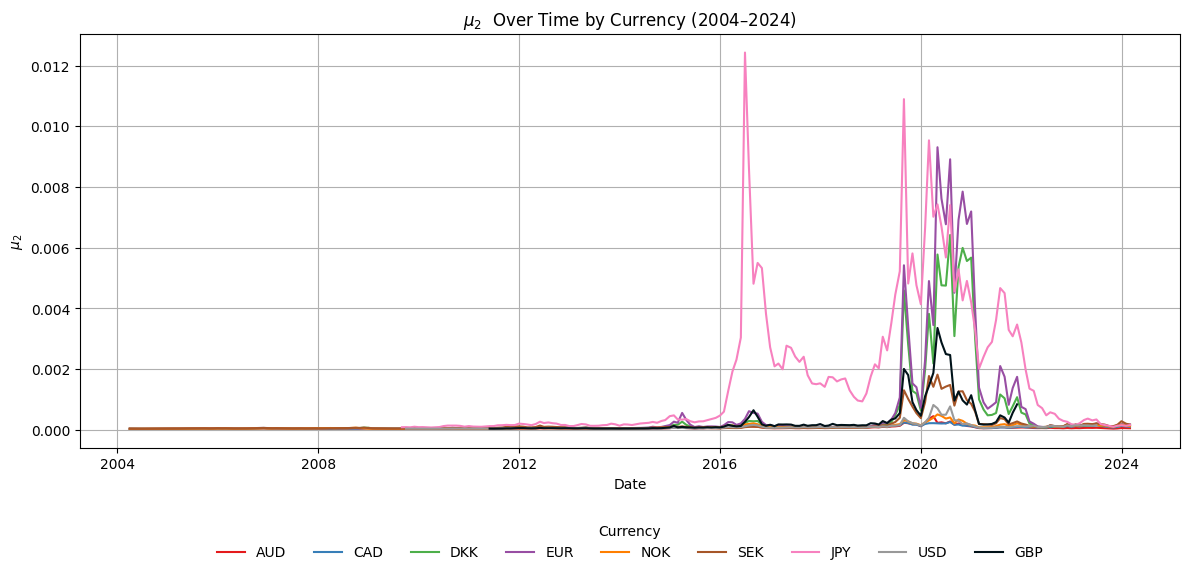

In [ ]:
legend_order = ['AUD', 'CAD', 'DKK', 'EUR', 'NOK', 'SEK', 'JPY', 'USD', "GBP"]
custom_palette = {
    'AUD': "#E41A1C", 'CAD': "#377EB8", 'DKK': "#4DAF4A", 'EUR': "#984EA3",
    'NOK': "#FF7F00", 'SEK': "#A65628", 'JPY': "#F781BF", 'USD': "#999999", "GBP": "#001219"
}

data_full = pd.read_csv("data_2_full.csv", parse_dates=["Date"])
maturity_cols = ['1Y', '2Y', '3Y', '5Y', '10Y', '15Y', '20Y', '30Y']
data_full["Year"] = data_full["Date"].dt.year
data_filtered = data_full[data_full["Year"].between(2004, 2024)].copy()

x_tensor = torch.tensor(data_filtered[maturity_cols].values, dtype=torch.float32)
dates = data_filtered["Date"].values
currencies = data_filtered["Currency"].values

model.eval()
forward_rates, discount_factors, swap_rates, drift_consistency, z, taus, mu_total, sigma1, sigma2, rho, short_rate = model(x_tensor)
mu1 = mu_total[:, 1].detach().cpu().numpy()

df_risk_neutral = pd.DataFrame({
    "Date": dates,
    "Currency": currencies,
    "sigma_1": mu1
})

plt.close('all')
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=df_risk_neutral,
    x="Date",
    y="sigma_1",
    hue="Currency",
    hue_order=legend_order,
    palette=custom_palette
)
plt.title(r"$\mu_2$  Over Time by Currency (2004–2024)")
plt.xlabel("Date")
plt.ylabel(r"$\mu_2$ ")
plt.grid(True)

plt.legend(
    title="Currency",
    loc="lower center",
    bbox_to_anchor=(0.5, -0.3),
    ncol=9,
    frameon=False
)

plt.tight_layout()
plt.show()

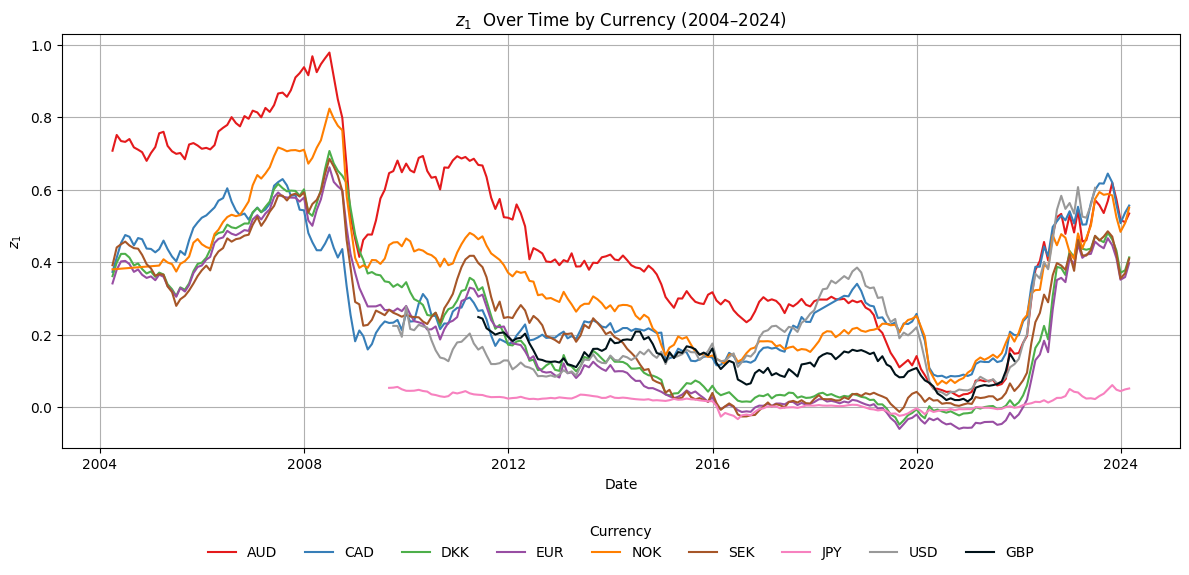

In [ ]:
legend_order = ['AUD', 'CAD', 'DKK', 'EUR', 'NOK', 'SEK', 'JPY', 'USD', "GBP"]
custom_palette = {
    'AUD': "#E41A1C", 'CAD': "#377EB8", 'DKK': "#4DAF4A", 'EUR': "#984EA3",
    'NOK': "#FF7F00", 'SEK': "#A65628", 'JPY': "#F781BF", 'USD': "#999999", "GBP": "#001219"
}

data_full = pd.read_csv("data_2_full.csv", parse_dates=["Date"])
maturity_cols = ['1Y', '2Y', '3Y', '5Y', '10Y', '15Y', '20Y', '30Y']
data_full["Year"] = data_full["Date"].dt.year
data_filtered = data_full[data_full["Year"].between(2004, 2024)].copy()

x_tensor = torch.tensor(data_filtered[maturity_cols].values, dtype=torch.float32)
dates = data_filtered["Date"].values
currencies = data_filtered["Currency"].values

model.eval()
forward_rates, discount_factors, swap_rates, drift_consistency, z, taus, mu_total, sigma1, sigma2, rho, short_rate = model(x_tensor)
mu1 = z[:, 0].detach().cpu().numpy()

df_risk_neutral = pd.DataFrame({
    "Date": dates,
    "Currency": currencies,
    "sigma_1": mu1
})

plt.close('all')
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=df_risk_neutral,
    x="Date",
    y="sigma_1",
    hue="Currency",
    hue_order=legend_order,
    palette=custom_palette
)
plt.title(r"$z_1$  Over Time by Currency (2004–2024)")
plt.xlabel("Date")
plt.ylabel(r"$z_1$ ")
plt.grid(True)

plt.legend(
    title="Currency",
    loc="lower center",
    bbox_to_anchor=(0.5, -0.3),
    ncol=9,
    frameon=False
)

plt.tight_layout()
plt.show()

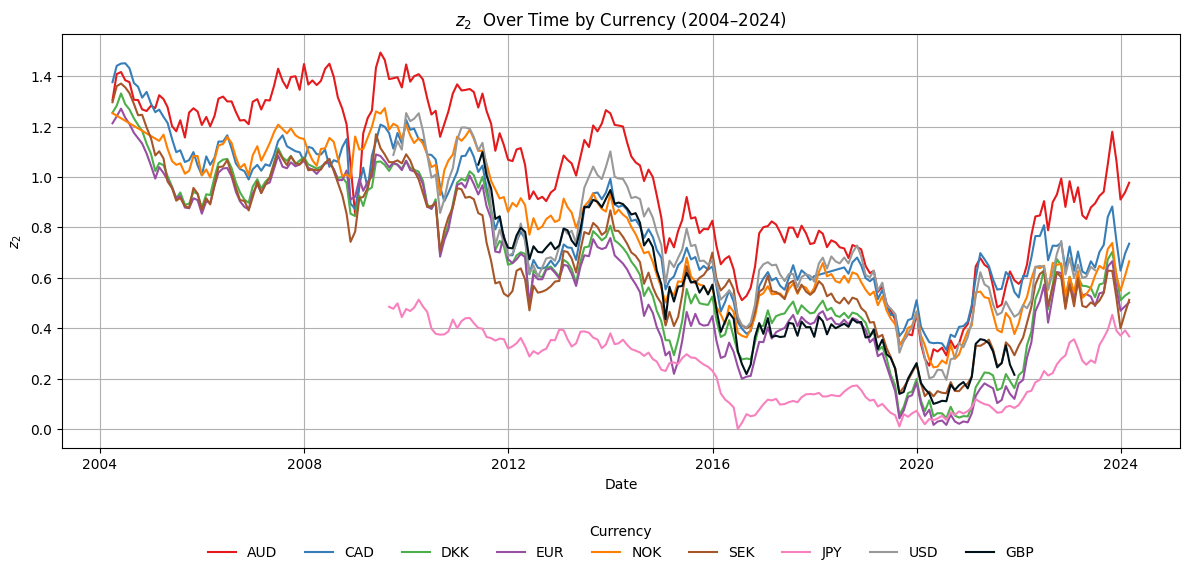

In [ ]:
legend_order = ['AUD', 'CAD', 'DKK', 'EUR', 'NOK', 'SEK', 'JPY', 'USD', "GBP"]
custom_palette = {
    'AUD': "#E41A1C", 'CAD': "#377EB8", 'DKK': "#4DAF4A", 'EUR': "#984EA3",
    'NOK': "#FF7F00", 'SEK': "#A65628", 'JPY': "#F781BF", 'USD': "#999999", "GBP": "#001219"
}

data_full = pd.read_csv("data_2_full.csv", parse_dates=["Date"])
maturity_cols = ['1Y', '2Y', '3Y', '5Y', '10Y', '15Y', '20Y', '30Y']
data_full["Year"] = data_full["Date"].dt.year
data_filtered = data_full[data_full["Year"].between(2004, 2024)].copy()

x_tensor = torch.tensor(data_filtered[maturity_cols].values, dtype=torch.float32)
dates = data_filtered["Date"].values
currencies = data_filtered["Currency"].values

model.eval()
forward_rates, discount_factors, swap_rates, drift_consistency, z, taus, mu_total, sigma1, sigma2, rho, short_rate = model(x_tensor)
mu1 = z[:, 1].detach().cpu().numpy()

df_risk_neutral = pd.DataFrame({
    "Date": dates,
    "Currency": currencies,
    "sigma_1": mu1
})

plt.close('all')
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=df_risk_neutral,
    x="Date",
    y="sigma_1",
    hue="Currency",
    hue_order=legend_order,
    palette=custom_palette
)
plt.title(r"$z_2$  Over Time by Currency (2004–2024)")
plt.xlabel("Date")
plt.ylabel(r"$z_2$ ")
plt.grid(True)

plt.legend(
    title="Currency",
    loc="lower center",
    bbox_to_anchor=(0.5, -0.3),
    ncol=9,
    frameon=False
)

plt.tight_layout()
plt.show()